# Metodologia e Variáveis
Em particular, incluímos o hiato do produto, a inflação passada, a variação da taxa de câmbio e a variação do preço das commodities no conjunto de regressores. A meta de inflação também entra como um regressor, pois espera-se que ele funcione como uma âncora para as expectativas de inflação. A equação estimada é a seguinte:

$$E_t \pi_{t,t+11} = \beta_1 + \beta_2 \bar{\pi}_{t,t+11} + \beta_3 \pi_{t-12,t-1} + \beta_4 (e_{t-1} - e_{t-7}) + \beta_5 (p_{t-1}^{c} - p_{t-7}^{c}) + \beta_6 h_{t-2} + \varepsilon_{t}$$

onde $E_t \pi_{t,t+11}$ é a expectativa de inflação para os próximos 12 meses, $\bar{\pi}_{t,t+11}$ é a meta de inflação para os próximos 12 meses, $\pi_{t-12,t-1}$ é a inflação acumulada nos últimos 12 meses, $e_t$ é a taxa de câmbio R\$/US\$, $p_{t}^{c}$ é o índice IC-br e $h_{t}$ é o hiato do produto obtido a partir do PIB mensal do IBRE/FGV via Filtro de Hamilton.

Com base na equação, verificaremos se a meta de inflação continua sendo importante para explicar o comportamento das expectativas. Importamos abaixo as variáveis utilizadas para estimar a equação, além da taxa de juros Selic, que será utilizada como instrumento.

# 1. Carregamento de bibliotecas

In [ ]:
!pip install python-bcb
!pip install linearmodels

In [ ]:
import pandas as pd # versão 2.0.3
import numpy as np
from plotnine import *
from linearmodels.iv import IV2SLS
from bcb import Expectativas, sgs
from functools import reduce
import statsmodels.formula.api as smf

# 2. Coleta de dados

## Expectativa de Inflação 12 meses

In [ ]:
# Instância a classe de Expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Inflação Acumulada em 12 meses
exp_ipca_raw = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

# Expectativa média do IPCA - tx. acumulada para os próximos 12 meses (Expectativas)
ipca_expec_12m_raw = (
    exp_ipca_raw.query()
    .filter(exp_ipca_raw.Suavizada == 'S',
            exp_ipca_raw.baseCalculo == 0,
            exp_ipca_raw.Indicador == 'IPCA')
    .collect()
    )

In [ ]:
ipca_expec_12m_raw

,Indicador,Data,Suavizada,Media,Mediana,DesvioPadrao,Minimo,Maximo,numeroRespondentes,baseCalculo
0,IPCA,2001-12-12,S,5.1700,5.2200,0.5600,NaN,NaN,NaN,0
1,IPCA,2001-12-13,S,5.1600,5.2200,0.5500,NaN,NaN,NaN,0
2,IPCA,2001-12-14,S,5.1300,5.1500,0.5700,NaN,NaN,NaN,0
3,IPCA,2001-12-17,S,5.1200,5.1600,0.5700,NaN,NaN,NaN,0
4,IPCA,2001-12-18,S,5.0900,5.1300,0.5800,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
5433,IPCA,2023-08-07,S,4.1714,4.1769,0.4132,2.7677,5.6195,135.0,0
5434,IPCA,2023-08-08,S,4.1762,4.1769,0.4154,2.7733,5.6260,135.0,0
5435,IPCA,2023-08-09,S,4.1757,4.1622,0.4136,2.7789,5.6294,135.0,0
5436,IPCA,2023-08-10,S,4.1756,4.1666,0.4119,2.7846,5.6389,135.0,0


In [ ]:
# Muda a classe da coluna de data para date time e period, renomeia as colunas e seleciona a coluna dos valores
ipca_expec_12m = (
    ipca_expec_12m_raw
    # altera o tipo da coluna de data para datetime
    .set_index(pd.to_datetime(ipca_expec_12m_raw['Data'])
    # altera o tipo da coluna para period
    .dt.to_period('D'))
    .rename(columns = {'Mediana' : 'ipca_exp_12m'})
    .loc[:, ['ipca_exp_12m']]
    .resample('M')
    .mean()
    .assign(Date = lambda x: pd.to_datetime(x.index.astype(str)))
    .reset_index(drop = True)
  )

In [ ]:
ipca_expec_12m

,ipca_exp_12m,Date
0,5.030000,2001-12-01
1,4.733636,2002-01-01
2,4.644737,2002-02-01
3,4.721500,2002-03-01
4,4.790000,2002-04-01
...,...,...
256,5.208222,2023-04-01
257,4.928914,2023-05-01
258,4.328971,2023-06-01
259,4.194614,2023-07-01


## Inflação acumulada em 12 meses, IC-br, Taxa de Câmbio (Compra) e Selic Anualizada 252

In [ ]:
# Coleta os dados
dados_sgs = sgs.get({"inflacao" : "13522",
                     'ic_br' : "27574",
                     'cambio' : '3697',
                    'selic' : '4189'})

# Diferença t e t - 7 do IC-br e Câmbio
dados_sgs = (
    dados_sgs
    .assign(delta_ic = lambda x: x.ic_br.diff(6),
            delta_dol = lambda x: x.cambio.diff(6))
    .reset_index()
)

In [ ]:
dados_sgs

,Date,inflacao,ic_br,cambio,selic,delta_ic,delta_dol
0,1980-12-01,99.25,NaN,NaN,NaN,NaN,NaN
1,1981-01-01,99.67,NaN,NaN,NaN,NaN,NaN
2,1981-02-01,103.07,NaN,NaN,NaN,NaN,NaN
3,1981-03-01,101.03,NaN,NaN,NaN,NaN,NaN
4,1981-04-01,103.27,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
508,2023-04-01,4.18,362.44,5.0191,13.65,-32.08,-0.2306
509,2023-05-01,3.94,345.47,4.9822,13.65,-54.02,-0.2919
510,2023-06-01,3.16,342.80,4.8510,13.65,-47.96,-0.3908
511,2023-07-01,3.99,349.10,4.8002,13.65,-31.57,-0.3999


## Meta de Inflação

In [ ]:
# Coleta a meta de inflação (anual)
meta = sgs.get({'meta' : "13521"})

# Cria a meta mensal
meta_m = (
    meta
    .loc[np.repeat(meta.index.values, 12)]
    .reset_index()
    .assign(Date = lambda x: pd.date_range(start = x['Date'].iloc[0],
                   periods = len(x),
                   freq = 'M').to_period('M')
    )
    .loc[:, ['Date', 'meta']]
    .assign(Date = lambda x: pd.to_datetime(x.Date.astype(str)))
  )

# Cria a meta 12 meses a frente
meta_m['meta_lead_12'] = meta_m['meta'].shift(-12)

In [ ]:
meta_m

,Date,meta,meta_lead_12
0,1999-01-01,8.0,6.0
1,1999-02-01,8.0,6.0
2,1999-03-01,8.0,6.0
3,1999-04-01,8.0,6.0
4,1999-05-01,8.0,6.0
...,...,...,...
319,2025-08-01,3.0,NaN
320,2025-09-01,3.0,NaN
321,2025-10-01,3.0,NaN
322,2025-11-01,3.0,NaN


## PIB Mensal FGV

In [ ]:
# Coleta os dados do PIB Mensal (FGV)
pib = pd.read_csv("https://aluno.analisemacro.com.br/download/53783/?tmstv=1692063478",
                  sep = ";",
                  parse_dates = ["data"],
                  decimal = ',').rename(columns = {"data" : "Date"})

<ipython-input-14-75ceb6ff5d83>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [ ]:
pib

,Date,pib
0,2000-01-01,108.7
1,2000-02-01,109.2
2,2000-03-01,109.3
3,2000-04-01,108.6
4,2000-05-01,110.4
...,...,...
276,2023-01-01,177.5
277,2023-02-01,182.8
278,2023-03-01,187.9
279,2023-04-01,186.1


## Hiato do Produto via Filtro de Hamilton

In [ ]:
# Regressão linear aplicando a especificação de Hamilton
reg3 = smf.ols(
    formula = "pib ~ pib.shift(24) + pib.shift(25) + pib.shift(26) + pib.shift(27)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_h = reg3.predict() # extrai os valores estimados

# Adiciona 27 NaNs no início da série para corresponder ao tamanho da série do PIB
potencial_h = np.append([np.nan]*27, potencial_h)
pib["pib_potencial"] = potencial_h
pib["hiato"] = (pib["pib"] / potencial_h - 1) * 100

<Axes: >

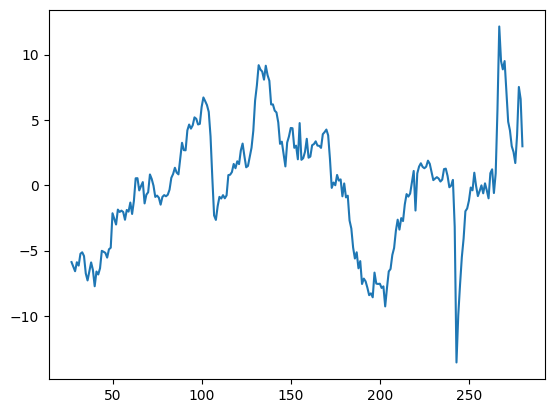

In [ ]:
# Verifica o Hiato do Produto
pib['hiato'].plot()

In [ ]:
pib

,Date,pib,pib_potencial,hiato
0,2000-01-01,108.7,NaN,NaN
1,2000-02-01,109.2,NaN,NaN
2,2000-03-01,109.3,NaN,NaN
3,2000-04-01,108.6,NaN,NaN
4,2000-05-01,110.4,NaN,NaN
...,...,...,...,...
276,2023-01-01,177.5,174.535501,1.698508
277,2023-02-01,182.8,176.053187,3.832258
278,2023-03-01,187.9,174.761999,7.517653
279,2023-04-01,186.1,174.594457,6.589867


## Junta os dados

In [ ]:
# lista de dataframes
dfs = [ipca_expec_12m, dados_sgs, meta_m, pib]

# reduz os dataframes pela chave 'Date' com left join
dados_reg = reduce(lambda left, right: pd.merge(left, right, on = 'Date', how = 'left'), dfs).dropna()

In [ ]:
dados_reg

,ipca_exp_12m,Date,inflacao,ic_br,cambio,selic,delta_ic,delta_dol,meta,meta_lead_12,pib,pib_potencial,hiato
4,4.790000,2002-04-01,7.98,56.23,2.3196,18.38,-11.59,-0.4198,3.50,4.0,114.4,121.546135,-5.879360
5,4.417619,2002-05-01,7.77,60.35,2.4796,18.37,-3.98,-0.0627,3.50,4.0,115.2,122.864936,-6.238506
6,4.417500,2002-06-01,7.66,66.65,2.7132,18.10,6.95,0.3513,3.50,4.0,115.4,123.526037,-6.578400
7,4.696087,2002-07-01,7.51,75.86,2.9338,18.17,14.81,0.5567,3.50,4.0,116.5,123.791502,-5.890147
8,4.975909,2002-08-01,7.46,80.62,3.1093,17.84,19.89,0.6905,3.50,4.0,116.7,124.342442,-6.146286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,5.406727,2023-01-01,5.77,380.67,5.2001,13.65,-36.95,-0.1674,3.25,3.0,177.5,174.535501,1.698508
254,5.662206,2023-02-01,5.60,374.72,5.1711,13.65,-39.91,0.0284,3.25,3.0,182.8,176.053187,3.832258
255,5.438104,2023-03-01,4.65,364.06,5.2109,13.65,-44.85,-0.0255,3.25,3.0,187.9,174.761999,7.517653
256,5.208222,2023-04-01,4.18,362.44,5.0191,13.65,-32.08,-0.2306,3.25,3.0,186.1,174.594457,6.589867


## Cria as defasagens

In [ ]:
# Defina as defasagens desejadas
defasagens = [1, 2]

# Crie as novas colunas conforme as defasagens
for defasagem in defasagens:
    dados_reg[f'meta_lead_shift_{defasagem}'] = dados_reg['meta_lead_12'].shift(defasagem)
    dados_reg[f'inflacao_shift_{defasagem}'] = dados_reg['inflacao'].shift(defasagem)
    dados_reg[f'delta_dol_shift_{defasagem}'] = dados_reg['delta_dol'].shift(defasagem)
    dados_reg[f'delta_ic_shift_{defasagem}'] = dados_reg['delta_ic'].shift(defasagem)
    dados_reg[f'hiato_shift_{defasagem}'] = dados_reg['hiato'].shift(defasagem)
    dados_reg[f'selic_shift_{defasagem}'] = dados_reg['selic'].shift(defasagem)

In [ ]:
# Retira os dados faltantes
dados_reg.dropna(inplace = True)

In [ ]:
dados_reg

,ipca_exp_12m,Date,inflacao,ic_br,cambio,selic,delta_ic,delta_dol,meta,meta_lead_12,...,delta_dol_shift_1,delta_ic_shift_1,hiato_shift_1,selic_shift_1,meta_lead_shift_2,inflacao_shift_2,delta_dol_shift_2,delta_ic_shift_2,hiato_shift_2,selic_shift_2
6,4.417500,2002-06-01,7.66,66.65,2.7132,18.10,6.95,0.3513,3.50,4.0,...,-0.0627,-3.98,-6.238506,18.37,4.00,7.98,-0.4198,-11.59,-5.879360,18.38
7,4.696087,2002-07-01,7.51,75.86,2.9338,18.17,14.81,0.5567,3.50,4.0,...,0.3513,6.95,-6.578400,18.10,4.00,7.77,-0.0627,-3.98,-6.238506,18.37
8,4.975909,2002-08-01,7.46,80.62,3.1093,17.84,19.89,0.6905,3.50,4.0,...,0.5567,14.81,-5.890147,18.17,4.00,7.66,0.3513,6.95,-6.578400,18.10
9,5.515714,2002-09-01,7.93,89.93,3.3412,17.89,31.38,0.9954,3.50,4.0,...,0.6905,19.89,-6.146286,17.84,4.00,7.51,0.5567,14.81,-5.890147,18.17
10,7.034348,2002-10-01,8.45,103.93,3.8051,19.59,47.70,1.4855,3.50,4.0,...,0.9954,31.38,-5.242602,17.89,4.00,7.46,0.6905,19.89,-6.146286,17.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,5.406727,2023-01-01,5.77,380.67,5.2001,13.65,-36.95,-0.1674,3.25,3.0,...,0.1932,-37.26,2.545514,13.65,3.25,5.90,0.3197,-32.62,2.987803,13.65
254,5.662206,2023-02-01,5.60,374.72,5.1711,13.65,-39.91,0.0284,3.25,3.0,...,-0.1674,-36.95,1.698508,13.65,3.25,5.79,0.1932,-37.26,2.545514,13.65
255,5.438104,2023-03-01,4.65,364.06,5.2109,13.65,-44.85,-0.0255,3.25,3.0,...,0.0284,-39.91,3.832258,13.65,3.00,5.77,-0.1674,-36.95,1.698508,13.65
256,5.208222,2023-04-01,4.18,362.44,5.0191,13.65,-32.08,-0.2306,3.25,3.0,...,-0.0255,-44.85,7.517653,13.65,3.00,5.60,0.0284,-39.91,3.832258,13.65


# 3. Estimação do Modelo

## OLS

In [ ]:
# Modelo via OLS
model_ols = IV2SLS.from_formula(
    formula = "ipca_exp_12m ~ 1 + meta_lead_12 + inflacao_shift_1 + delta_dol_shift_1 + delta_ic_shift_1 + hiato_shift_2",  # especificação do modelo no formato de fórmula
    data = dados_reg  # fonte dos dados
    ).fit(cov_type = 'kernel', kernel = 'bartlett') # estima o modelo

In [ ]:
# Imprimindo o sumário do modelo
print(model_ols.summary)

                            OLS Estimation Summary                            
Dep. Variable:           ipca_exp_12m   R-squared:                      0.6617
Estimator:                        OLS   Adj. R-squared:                 0.6548
No. Observations:                 252   F-statistic:                    70.019
Date:                Wed, Aug 16 2023   P-value (F-stat)                0.0000
Time:                        20:37:04   Distribution:                  chi2(5)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.2020     1.1134     0.1815     0.8560     -1.9802      2.3842
meta_lead_12          0.

## IV2SLS

In [ ]:
# Estimando o modelo 2SLS sem restrição usando a função IV2SLS.from_formula
model_2sls = IV2SLS.from_formula(
    'ipca_exp_12m ~ 1 + [meta_lead_12 + inflacao_shift_1 + delta_dol_shift_1 + delta_ic_shift_1 + hiato_shift_2 ~ meta_lead_shift_2 + meta_lead_shift_2 + inflacao_shift_1 + inflacao_shift_2 + delta_dol_shift_1 + delta_dol_shift_2 + delta_ic_shift_1 + hiato_shift_2 + selic_shift_1 + selic_shift_2]',
    data=dados_reg
).fit(cov_type = 'kernel', kernel = 'bartlett')

# Imprimindo o sumário do modelo
print(model_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           ipca_exp_12m   R-squared:                      0.6617
Estimator:                    IV-2SLS   Adj. R-squared:                 0.6548
No. Observations:                 252   F-statistic:                    68.934
Date:                Wed, Aug 16 2023   P-value (F-stat)                0.0000
Time:                        20:38:13   Distribution:                  chi2(5)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             0.1111     1.1020     0.1008     0.9197     -2.0488      2.2711
meta_lead_12          0.

## Comparação de Modelos

Realizamos uma comparação dos coeficiente estimados de ambos os modelos abaixo:

In [ ]:
# Compara os modelos
from linearmodels.iv import compare # módulo para comparar os modelos
print(compare({"OLS": model_ols, "2SLS": model_2sls}))

                     Model Comparison                     
                                   OLS                2SLS
----------------------------------------------------------
Dep. Variable             ipca_exp_12m        ipca_exp_12m
Estimator                          OLS             IV-2SLS
No. Observations                   252                 252
Cov. Est.                       kernel              kernel
R-squared                       0.6617              0.6617
Adj. R-squared                  0.6548              0.6548
F-statistic                     70.019              68.934
P-value (F-stat)             1.015e-13           1.708e-13
===================     ==============      ==============
Intercept                       0.2020              0.1111
                              (0.1815)            (0.1008)
meta_lead_12                    0.6336              0.6556
                              (2.7413)            (2.8141)
inflacao_shift_1                0.3377              0.33

## Rolling Regression

### OLS

De forma a compreender a relação dinâmica entre as variáveis, estimamos uma regressão em janelas deslizantes de 48 meses de forma a obter o coeficiente beta de cada variável. Abaixo, os coeficientes estimado via OLS.

In [ ]:
# Tamanho da janela deslizante
window_size = 48

# Número de observações
n_obs = len(dados_reg)

# Lista para armazenar os resultados das regressões
results = []

# Variáveis independentes a serem analisadas
independent_vars = ['meta_lead_12', 'inflacao_shift_1', 'delta_dol_shift_1', 'delta_ic_shift_1', 'hiato_shift_2']

# Loop sobre as subamostras
for i in range(n_obs - window_size + 1):
    sub_sample = dados_reg[i:i+window_size]

    # Estimar o modelo OLS para a subamostra atual
    model_ols = smf.ols(
        formula="ipca_exp_12m ~ 1 + meta_lead_12 + inflacao_shift_1 + delta_dol_shift_1 + delta_ic_shift_1 + hiato_shift_2",
        data = sub_sample
    ).fit(cov_type='HAC', cov_kwds={'maxlags': round(len(sub_sample)**(1/4))})

    # Armazenar os resultados
    result = {
        'start_date': sub_sample['Date'].iloc[0],
        'end_date': sub_sample['Date'].iloc[-1]
    }

    for var in independent_vars:
        result[f'beta_{var}'] = model_ols.params[var]
        result[f'ci_lower_{var}'] = model_ols.conf_int().loc[var][0]
        result[f'ci_upper_{var}'] = model_ols.conf_int().loc[var][1]

    results.append(result)

# Converter os resultados para um DataFrame
results_df = pd.DataFrame(results)

In [ ]:
results_df

,start_date,end_date,beta_meta_lead_12,ci_lower_meta_lead_12,ci_upper_meta_lead_12,beta_inflacao_shift_1,ci_lower_inflacao_shift_1,ci_upper_inflacao_shift_1,beta_delta_dol_shift_1,ci_lower_delta_dol_shift_1,ci_upper_delta_dol_shift_1,beta_delta_ic_shift_1,ci_lower_delta_ic_shift_1,ci_upper_delta_ic_shift_1,beta_hiato_shift_2,ci_lower_hiato_shift_2,ci_upper_hiato_shift_2
0,2002-06-01,2006-05-01,-0.037914,-1.196279,1.120451,0.474731,0.253393,0.696069,1.839543,-0.601631,4.280718,0.035481,-0.036806,0.107768,0.242834,0.008418,0.477250
1,2002-07-01,2006-06-01,-0.132168,-1.267509,1.003173,0.483848,0.272166,0.695531,1.804766,-0.616100,4.225632,0.035355,-0.037098,0.107807,0.237359,-0.014606,0.489324
2,2002-08-01,2006-07-01,-0.196746,-1.232472,0.838980,0.470806,0.284350,0.657262,2.026591,-0.294252,4.347435,0.026977,-0.042365,0.096319,0.205294,-0.050328,0.460915
3,2002-09-01,2006-08-01,-0.274109,-1.233147,0.684928,0.440679,0.289456,0.591902,2.441269,0.300499,4.582039,0.012667,-0.049514,0.074847,0.142249,-0.088737,0.373235
4,2002-10-01,2006-09-01,-0.542178,-1.491199,0.406843,0.434361,0.326796,0.541926,2.870879,1.063573,4.678185,-0.000828,-0.050362,0.048706,0.081480,-0.101419,0.264379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2019-02-01,2023-01-01,-1.017083,-1.488970,-0.545196,0.183946,0.131979,0.235913,-0.088394,-0.431799,0.255011,-0.007103,-0.009854,-0.004351,0.013567,-0.017278,0.044412
201,2019-03-01,2023-02-01,-1.197090,-1.581035,-0.813146,0.174979,0.123617,0.226342,-0.135535,-0.448033,0.176963,-0.007502,-0.009861,-0.005143,0.007989,-0.019770,0.035747
202,2019-04-01,2023-03-01,-1.251726,-1.590631,-0.912822,0.174023,0.125376,0.222671,-0.118507,-0.416002,0.178987,-0.007358,-0.009511,-0.005205,0.007872,-0.018298,0.034041
203,2019-05-01,2023-04-01,-1.216879,-1.523260,-0.910498,0.176431,0.131302,0.221560,-0.124335,-0.424060,0.175390,-0.007480,-0.009680,-0.005280,0.007242,-0.019044,0.033528


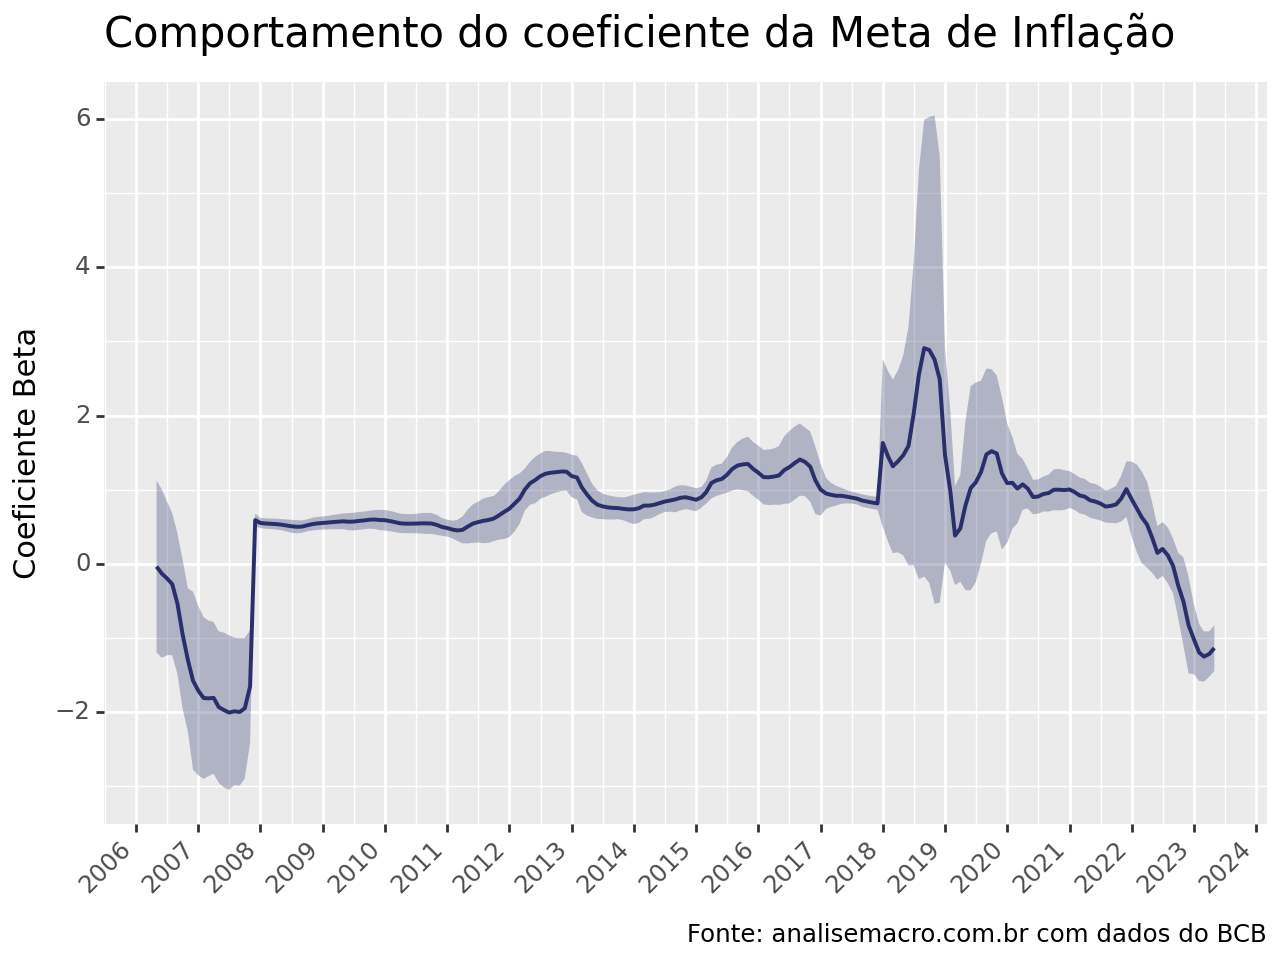

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(results_df, aes(x='end_date', y='beta_meta_lead_12'))
    + geom_line(size=0.8, color="#282f6b")
    + geom_ribbon(aes(ymin='ci_lower_meta_lead_12', ymax='ci_upper_meta_lead_12'),
                  fill="#282f6b", alpha=0.3, linetype="dashed")
    + labs(x='', y='Coeficiente Beta', title='Comportamento do coeficiente da Meta de Inflação',
           caption='Fonte: analisemacro.com.br com dados do BCB')
    + scale_x_datetime(date_breaks="1 years", date_labels="%Y")
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
        plot_title=element_text(size=15)
    )
)

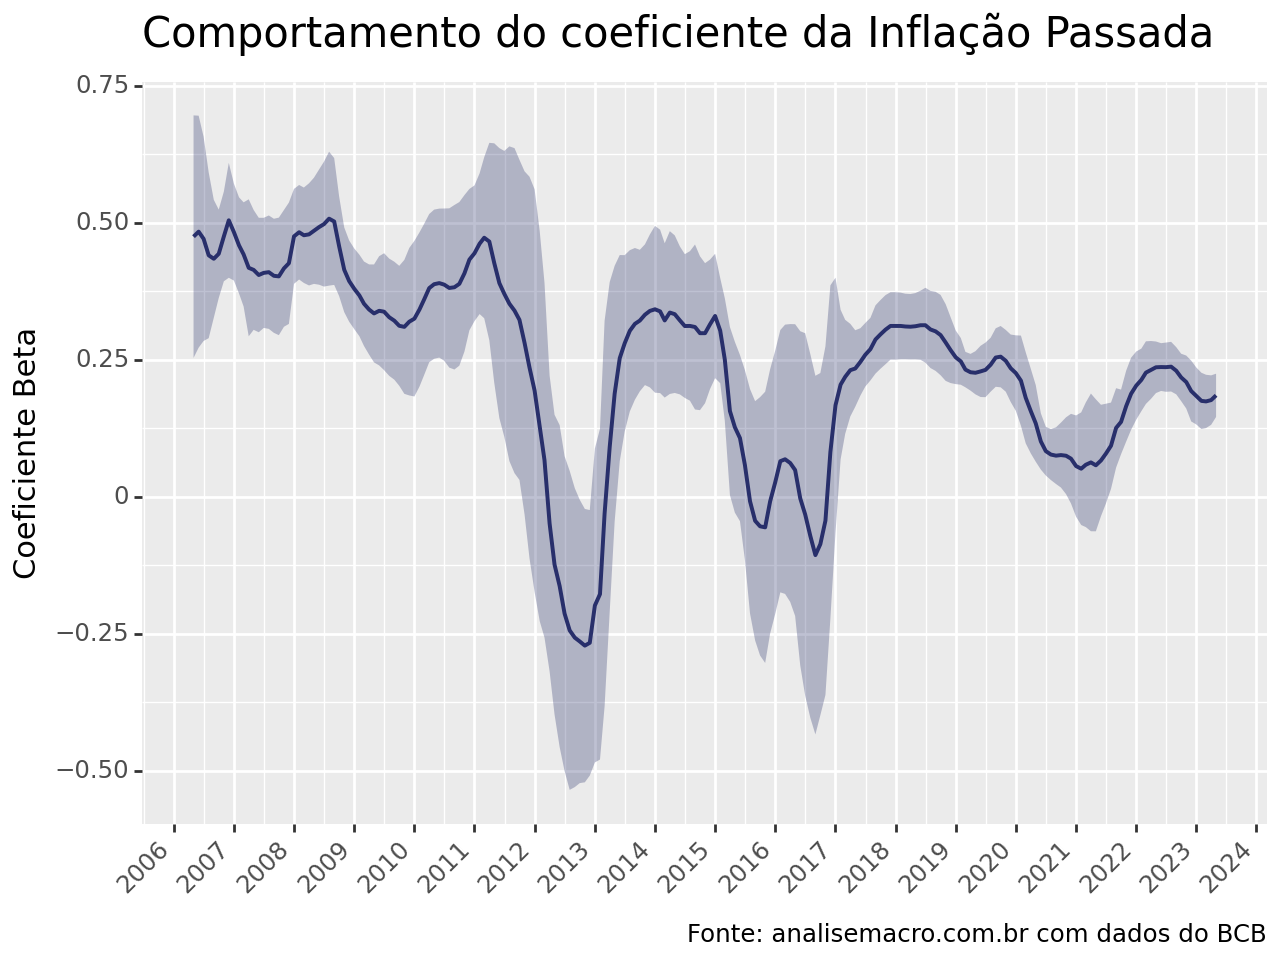

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(results_df, aes(x='end_date', y='beta_inflacao_shift_1'))
    + geom_line(size=0.8, color="#282f6b")
    + geom_ribbon(aes(ymin='ci_lower_inflacao_shift_1', ymax='ci_upper_inflacao_shift_1'),
                  fill="#282f6b", alpha=0.3, linetype="dashed")
    + labs(x='', y='Coeficiente Beta', title='Comportamento do coeficiente da Inflação Passada',
           caption='Fonte: analisemacro.com.br com dados do BCB')
    + scale_x_datetime(date_breaks="1 years", date_labels="%Y")
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
        plot_title=element_text(size=15)
    )
)

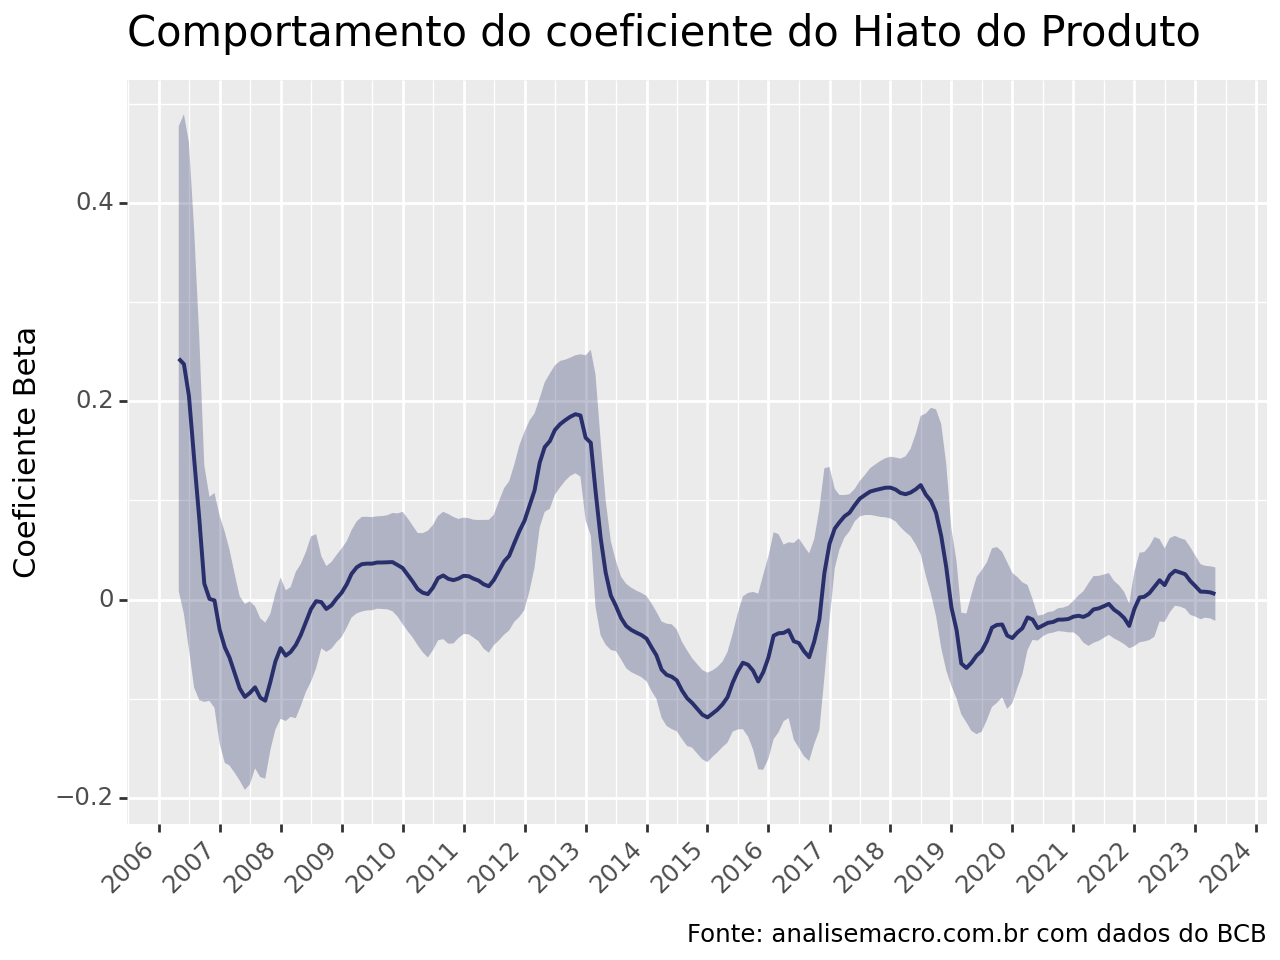

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(results_df, aes(x='end_date', y='beta_hiato_shift_2'))
    + geom_line(size=0.8, color="#282f6b")
    + geom_ribbon(aes(ymin='ci_lower_hiato_shift_2', ymax='ci_upper_hiato_shift_2'),
                  fill="#282f6b", alpha=0.3, linetype="dashed")
    + labs(x='', y='Coeficiente Beta', title='Comportamento do coeficiente do Hiato do Produto',
           caption='Fonte: analisemacro.com.br com dados do BCB')
    + scale_x_datetime(date_breaks="1 years", date_labels="%Y")
    + theme(
        axis_text_x=element_text(angle=45, hjust=1),
        plot_title=element_text(size=15)
    )
)

### IV2SLS

In [ ]:
# Tamanho da janela deslizante
window_size = 170

# Número de observações
n_obs = len(dados_reg)

# Lista para armazenar os resultados das regressões
results = []

# Variáveis independentes a serem analisadas
independent_vars = ['meta_lead_12', 'inflacao_shift_1', 'delta_dol_shift_1', 'hiato_shift_2']
instrumental_vars = ['meta_lead_shift_2', 'meta_lead_shift_2', 'inflacao_shift_1', 'inflacao_shift_2', 'delta_dol_shift_1', 'delta_dol_shift_2', 'delta_ic_shift_1', 'hiato_shift_2', 'selic_shift_1', 'selic_shift_2']

# Loop sobre as subamostras
for i in range(n_obs - window_size + 1):
    sub_sample = dados_reg[i:i+window_size]

    # Construir a fórmula para o modelo
    formula = 'ipca_exp_12m ~ 1 + [' + ' + '.join(independent_vars) + '~' + ' + '.join(instrumental_vars) + ']'

    # Estimar o modelo 2SLS para a subamostra atual
    model = IV2SLS.from_formula(formula, data=sub_sample).fit(cov_type = 'robust')

    # Armazenar os resultados
    result = {
        'start_date': sub_sample['Date'].iloc[0],
        'end_date': sub_sample['Date'].iloc[-1]
    }

    for var in independent_vars:
        result[f'beta_{var}'] = model.params[var]
        result[f'ci_lower_{var}'] = model.conf_int().loc[var][0]
        result[f'ci_upper_{var}'] = model.conf_int().loc[var][1]

    results.append(result)

# Converter os resultados para um DataFrame
results_df = pd.DataFrame(results)